In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd

In [4]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR = "fashionMNSITDir"
    self.epochs = 10
    self.batch_size= 32
    self.learning_rate = 0.01
    self.image_size = (28,28)
    self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
    print(f"this notebook is using Device: {self.DEVICE}")
    self.SEED = 2022

config = Config()



this notebook is using Device: cpu


In [9]:
train_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()

)

test_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = False,
    download = True,
    transform = transforms.ToTensor()

)

In [7]:
from torchvision import transforms, datasets
dir(datasets)

['CIFAR10',
 'CIFAR100',
 'CLEVRClassification',
 'CREStereo',
 'Caltech101',
 'Caltech256',
 'CarlaStereo',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'Country211',
 'DTD',
 'DatasetFolder',
 'EMNIST',
 'ETH3DStereo',
 'EuroSAT',
 'FER2013',
 'FGVCAircraft',
 'FakeData',
 'FallingThingsStereo',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'Flowers102',
 'FlyingChairs',
 'FlyingThings3D',
 'Food101',
 'GTSRB',
 'HD1K',
 'HMDB51',
 'INaturalist',
 'ImageFolder',
 'ImageNet',
 'Imagenette',
 'InStereo2k',
 'KMNIST',
 'Kinetics',
 'Kitti',
 'Kitti2012Stereo',
 'Kitti2015Stereo',
 'KittiFlow',
 'LFWPairs',
 'LFWPeople',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Middlebury2014Stereo',
 'MovingMNIST',
 'Omniglot',
 'OxfordIIITPet',
 'PCAM',
 'PhotoTour',
 'Places365',
 'QMNIST',
 'RenderedSST2',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SUN397',
 'SVHN',
 'SceneFlowStereo',
 'Sintel',
 'SintelStereo',
 'StanfordCars',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 

In [56]:
given_label_map = train_data.class_to_idx
given_label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [57]:
label_map = {v:k for k,v in given_label_map.items()}
label_map


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [15]:
def view_sample_img(data,index,label_map):
  plt.imshow(data.data[index] , cmap ="gray")
  plt.title(f"{label_map[data.targets[index].item()]}")


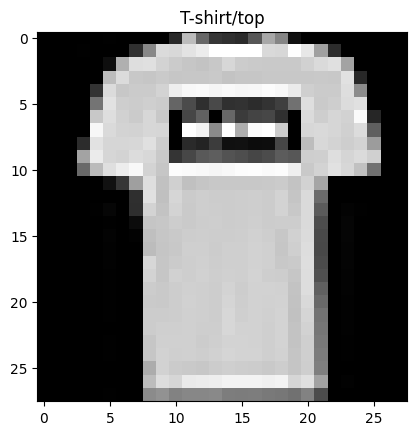

In [16]:
view_sample_img(train_data,1,label_map)

In [17]:
train_data_loader = DataLoader(train_data,batch_size=config.batch_size,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=config.batch_size,shuffle=True)

In [18]:
for images,labels in train_data_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [20]:
images[0].shape

torch.Size([1, 28, 28])

In [41]:
# Define CNN architecture
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()

        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)

    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = F.relu(x)
        x = self.FC_02(x)
        x = F.relu(x)
        x = self.FC_03(x)
        x = F.log_softmax(x, dim=1)  # Apply softmax to the final layer output
        return x


In [42]:

model=CNN(1,10)

print(model)


CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [43]:

def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0}
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total parameters: {total}")
  return df

count_params(model)


,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=config.learning_rate)

In [45]:
for epoch in range(config.epochs):
  with tqdm(train_data_loader, unit="batch") as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch}")
      images = images.to(config.DEVICE)
      labels = labels.to(config.DEVICE)

      output = model(images)
      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tqdm_epoch.set_postfix(loss=loss.item())
#

Epoch 9: 100%|██████████| 1875/1875 [00:51<00:00, 36.58batch/s, loss=0.4]


In [46]:

os.makedirs("model_dir",exist_ok=True)
model_file_path= os.path.join("model_dir","CNN_model.pth")
torch.save(model,model_file_path)



In [47]:

loaded_model=torch.load(model_file_path)

In [50]:

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        images = images.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Accuracy: 84.37%


In [52]:

def predict(data,model,label_map,device,idx=0):
  images,labels=data
  img=images[idx]
  labels=labels[idx]

  plt.imshow(img.squeeze(),cmap='gray')
  logit=model(img.unsqueeze(dim=1).to(config.DEVICE))
  pred_prob=F.softmax(logit,dim=1)
  argmax=(torch.argmax(pred_prob)).item()
  predicted_label=label_map[argmax]
  actual_label =label_map[label.item()]

  plt.title(f"actual: {actual_label}| predicted : {predicted_label}")
  plt.axis("off")
  return predicted_label, actual_label

NameError: name 'label' is not defined

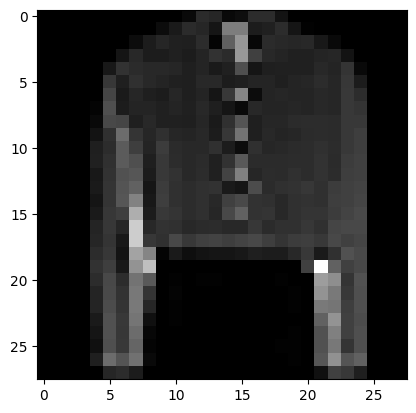

In [53]:
# Load a batch of test data
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
data = next(iter(test_loader))

# Predict and plot
predicted_label, actual_label = predict(data, model, label_map, config.DEVICE, idx=0)

In [60]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict(data, model, label_map, device, idx=0):
    images, labels = data
    img = images[idx]
    label = labels[idx]

    plt.imshow(img.squeeze(), cmap='gray')
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    model.eval()
    with torch.no_grad():
        logit = model(img)
        pred_prob = F.softmax(logit, dim=1)
        argmax = torch.argmax(pred_prob, dim=1).item()

    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]

    plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label, actual_label


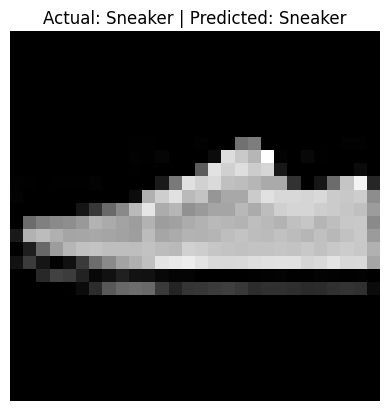

In [61]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Assuming you have test_data and the model is already loaded and moved to device
test_data = datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
data = next(iter(test_loader))

# Predict and plot
predicted_label, actual_label = predict(data, model, label_map, config.DEVICE, idx=0)
